In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import rebound
import matplotlib.pyplot as plt
import numpy as np
import vanillaWH
import vanillaWH_tools

%matplotlib inline

# configuring plots
#plt.rc('text', usetex=True)            # use LaTeX for text
plt.rc('font', family='serif')          # use serif font
plt.rcParams.update({'font.size': 14})  # increase font size

In [8]:
# initial conditions from Mikkola 1997
# could also late test w/ restricted 3-body problem: https://w.astro.berkeley.edu/~echiang/classmech/final.pdf

# particle array as [x, y, z, vx, vy, vz, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([-1, 0., 0., 0., -0.7, 0., 2.])
p2 = np.array([0., 60., 0.01, -0.095, 0.0, 0.01, 0.9])

sim_jacobi = np.stack([p0, p1, p2])
masses = sim_jacobi[:,-1]

sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

timestep = 1./30.
N_steps = 50000

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim_jacobi)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0], orbit_soln[:,2,0] = sim_jacobi[:,0], sim_jacobi[:,1], sim_jacobi[:,2]

start = time.time()

for i in range(N_steps):
    
    # drift
    sim_jacobi = vanillaWH.drift(sim_jacobi, sim, object_num = 1, h=timestep/2)
    sim_jacobi = vanillaWH.drift(sim_jacobi, sim, object_num = 2, h=timestep/2)
    sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)
    
    # kick
    sim_jacobi = vanillaWH.kick(sim_jacobi, sim, h=timestep)
    
    # drift
    sim_jacobi = vanillaWH.drift(sim_jacobi, sim, object_num = 1, h=timestep/2)
    sim_jacobi = vanillaWH.drift(sim_jacobi, sim, object_num = 2, h=timestep/2)
    sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    E = vanillaWH_tools.energy_fn(sim_jacobi)
    energy_error[i] = (E-E0)/E0

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 31.5 s


Integrate with timestep = 0.03333333333333333 for 50000 steps = 265.2529333217225 years.


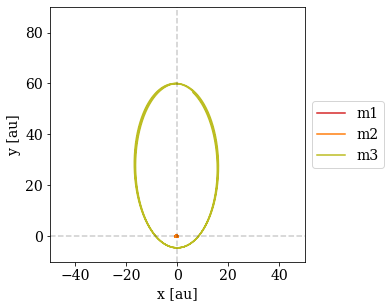

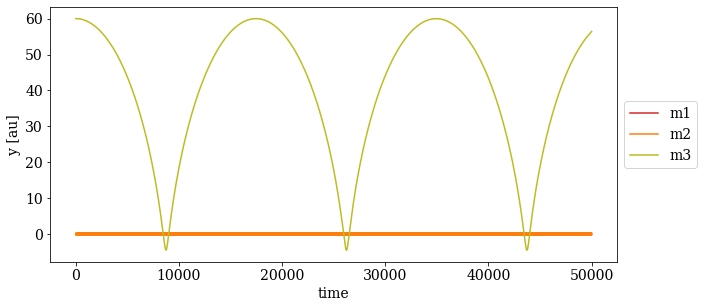

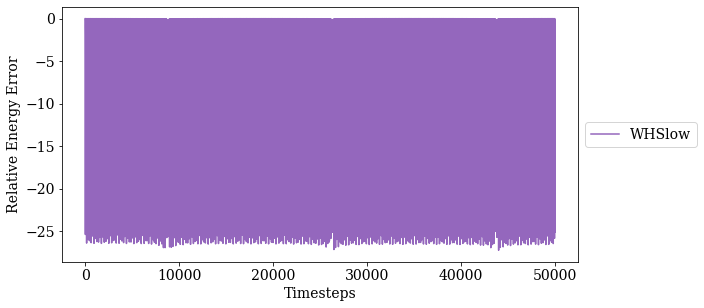

In [9]:
years = timestep * np.arange(N_steps) / (2*np.pi)
print('Integrate with timestep =', timestep, 'for', N_steps, 'steps =', years[-1], 'years.')

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], label='m1', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], label='m2', c='tab:orange')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], label='m3', c='tab:olive')
#plt.plot(orbit_soln[0,0], orbit_soln[0,1], lw=10, alpha=0.2, label='Sun, WHSlow', c='tab:red')
#plt.plot(orbit_soln[1,0], orbit_soln[1,1], lw=10, alpha=0.2, label='Jupiter, WHSlow', c='tab:orange')
#plt.plot(orbit_soln[2,0], orbit_soln[2,1], lw=10, alpha=0.2, label='Saturn, WHSlow', c='tab:olive')
#plt.plot(orbit_soln_rebound[0,0], orbit_soln_rebound[0,1], label='Sun, WHFast', c='tab:red')
#plt.plot(orbit_soln_rebound[1,0], orbit_soln_rebound[1,1], label='Jupiter, WHFast', c='tab:orange')
#plt.plot(orbit_soln_rebound[2,0], orbit_soln_rebound[2,1], label='Saturn, WHFast', c='tab:olive')
plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
plt.xlim(-50,50)
plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,1], label='m1', c='tab:red')
plt.plot(orbit_soln[1,1], label='m2', c='tab:orange')
plt.plot(orbit_soln[2,1], label='m3', c='tab:olive')
plt.xlabel('time')
plt.ylabel('y [au]')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(np.arange(N_steps), energy_error, label='WHSlow', c='tab:purple')
#plt.yscale('log')
#plt.ylim(1e-7, 1e-4)
plt.xlabel('Timesteps')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()


In [5]:
# particle array as [x, y, z, vx, vy, vz, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([-1, 0., 0., 0., -0.7, 0., 2.])
p2 = np.array([0., 60., 0.01, -0.095, 0.0, 0.01, 0.9])

sim_jacobi = np.stack([p0, p1, p2])
masses = sim_jacobi[:,-1]

print('jacobi', sim_jacobi)

sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

print('inertial', sim)

sim_jacobi2 = vanillaWH_tools.inertial_to_jacobi(sim)

print('jacobi', sim_jacobi2)

sim3 = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

print('inertial', sim3)

print('subtract', sim-sim3)

jacobi [[ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00]
 [-1.0e+00  0.0e+00  0.0e+00  0.0e+00 -7.0e-01  0.0e+00  2.0e+00]
 [ 0.0e+00  6.0e+01  1.0e-02 -9.5e-02  0.0e+00  1.0e-02  9.0e-01]]
inertial [[ 6.66666667e-01 -1.38461538e+01 -2.30769231e-03  2.19230769e-02
   4.66666667e-01 -2.30769231e-03  1.00000000e+00]
 [-3.33333333e-01 -1.38461538e+01 -2.30769231e-03  2.19230769e-02
  -2.33333333e-01 -2.30769231e-03  2.00000000e+00]
 [ 0.00000000e+00  4.61538462e+01  7.69230769e-03 -7.30769231e-02
   0.00000000e+00  7.69230769e-03  9.00000000e-01]]
jacobi [[ 0.00000000e+00 -1.82190445e-15  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.90000000e+00]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.00000000e-01  0.00000000e+00  6.66666667e-01]
 [ 0.00000000e+00  6.00000000e+01  1.00000000e-02 -9.50000000e-02
   0.00000000e+00  1.00000000e-02  6.92307692e-01]]
inertial [[ 6.66666667e-01 -1.38461538e+01 -2.30769231e-03  2.19230769e-02

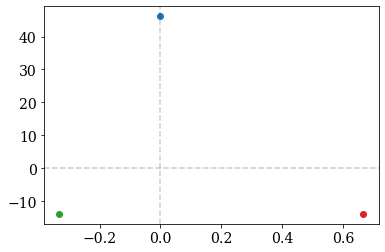

In [7]:
plt.scatter(sim[0,0], sim[0,1], c='tab:red')
plt.scatter(sim[1,0], sim[1,1], c='tab:green')
plt.scatter(sim[2,0], sim[2,1], c='tab:blue')
plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.show()

In [ ]:
### todo: change to inertial coord, integrate with rebound?

SS.integrator='whfast'
SS.dt = timestep
SS.move_to_com()

energy_error_reb = np.zeros(N_steps) 
E0 = SS.calculate_energy()

orbit_soln_rebound = np.zeros((len(sim), 3, N_steps))
diff0, diff1, diff2 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)
diff3, diff4, diff5 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)

rel_diff0, rel_diff1, rel_diff2 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)
rel_diff3, rel_diff4, rel_diff5 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)

start = time.time()

for i in range(N_steps):
    SS.step() 
    
    E = SS.calculate_energy()
    energy_error_reb[i] = np.abs((E-E0)/E0)
    
    orbit_soln_rebound[0,:,i] = SS.particles[0].x, SS.particles[0].y, SS.particles[0].z
    orbit_soln_rebound[1,:,i] = SS.particles[1].x, SS.particles[1].y, SS.particles[1].z
    orbit_soln_rebound[2,:,i] = SS.particles[2].x, SS.particles[2].y, SS.particles[2].z
    orbit_soln_rebound[3,:,i] = SS.particles[3].x, SS.particles[3].y, SS.particles[3].z
    orbit_soln_rebound[4,:,i] = SS.particles[4].x, SS.particles[4].y, SS.particles[4].z
    orbit_soln_rebound[5,:,i] = SS.particles[5].x, SS.particles[5].y, SS.particles[5].z
    
    x0 = orbit_soln_rebound[0,0,i]
    y0 = orbit_soln_rebound[0,1,i]
    z0 = orbit_soln_rebound[0,2,i]
    dx0 = x0-orbit_soln[0,0,i]
    dy0 = y0-orbit_soln[0,1,i]
    dz0 = z0-orbit_soln[0,2,i]
    diff0[i] = np.sqrt(dx0**2 + dy0**2 + dz0**2)
    rel_diff0[i] = diff0[i] / np.sqrt(x0**2 + y0**2 + z0**2)
    
    x1 = orbit_soln_rebound[1,0,i]
    y1 = orbit_soln_rebound[1,1,i]
    z1 = orbit_soln_rebound[1,2,i]
    dx1 = x1-orbit_soln[1,0,i]
    dy1 = y1-orbit_soln[1,1,i]
    dz1 = z1-orbit_soln[1,2,i]
    diff1[i] = np.sqrt(dx1**2 + dy1**2 + dz1**2)
    rel_diff1[i] = diff1[i] / np.sqrt(x1**2 + y1**2 + z1**2)
    
    x2 = orbit_soln_rebound[2,0,i]
    y2 = orbit_soln_rebound[2,1,i]
    z2 = orbit_soln_rebound[2,2,i]
    dx2 = x2-orbit_soln[2,0,i]
    dy2 = y2-orbit_soln[2,1,i]
    dz2 = z2-orbit_soln[2,2,i]
    diff2[i] = np.sqrt(dx2**2 + dy2**2 + dz2**2)
    rel_diff2[i] = diff2[i] / np.sqrt(x2**2 + y2**2 + z2**2)
    
    x3 = orbit_soln_rebound[3,0,i]
    y3 = orbit_soln_rebound[3,1,i]
    z3 = orbit_soln_rebound[3,2,i]
    dx3 = x3-orbit_soln[3,0,i]
    dy3 = y3-orbit_soln[3,1,i]
    dz3 = z3-orbit_soln[3,2,i]
    diff3[i] = np.sqrt(dx3**2 + dy3**2 + dz3**2)
    rel_diff3[i] = diff3[i] / np.sqrt(x3**2 + y3**2 + z3**2)
    
    x4 = orbit_soln_rebound[4,0,i]
    y4 = orbit_soln_rebound[4,1,i]
    z4 = orbit_soln_rebound[4,2,i]
    dx4 = x4-orbit_soln[4,0,i]
    dy4 = y4-orbit_soln[4,1,i]
    dz4 = z4-orbit_soln[4,2,i]
    diff4[i] = np.sqrt(dx4**2 + dy4**2 + dz4**2)
    rel_diff4[i] = diff4[i] / np.sqrt(x4**2 + y4**2 + z4**2)
    
    x5 = orbit_soln_rebound[5,0,i]
    y5 = orbit_soln_rebound[5,1,i]
    z5 = orbit_soln_rebound[5,2,i]
    dx5 = x5-orbit_soln[5,0,i]
    dy5 = y5-orbit_soln[5,1,i]
    dz5 = z5-orbit_soln[5,2,i]
    diff5[i] = np.sqrt(dx5**2 + dy5**2 + dz5**2)
    rel_diff5[i] = diff5[i] / np.sqrt(x5**2 + y5**2 + z5**2)
    
end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')